In [1]:
pip install --upgrade jupyter ipywidgets
%pip install matplotlib
%pip install scikit-learn
pip install sentence_transformers
%pip install nltk
%pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
from threadpoolctl import threadpool_limits

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

from joblib import threadpool_limits

import torch
print(torch.__version__)
from torch import nn
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
import nltk
import re


2.2.2


In [4]:
### BertTokenizer: Classifier From hugging face

In [5]:
### Import Data

In [4]:
data = pd.read_pickle("/Users/yfd/Downloads/motley-fool-data.pkl")

In [5]:
data

,date,exchange,q,ticker,transcript
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...
...,...,...,...,...,...
18750,"Nov 9, 2021, 1:00 p.m. ET",NYSE: SWX,2021-Q3,SWX,Prepared Remarks:\nOperator\nLadies and gentle...
18751,"Nov 18, 2021, 12:00 p.m. ET",NYSE: PNNT,2021-Q4,PNNT,"Prepared Remarks:\nOperator\nGood morning, and..."
18752,"Feb 08, 2022, 11:00 a.m. ET",NYSE: TDG,2022-Q1,TDG,Prepared Remarks:\nOperator\nThank you for sta...
18753,"Feb 28, 2022, 4:30 p.m. ET",NASDAQ: DVAX,2021-Q4,DVAX,"Prepared Remarks:\nOperator\nGood day, ladies ..."


In [6]:
data["transcript"].iloc[0]

"Prepared Remarks:\nOperator\nGood day, and welcome to the Bilibili 2020 Second Quarter Earnings Conference Call. Today's conference is being recorded.\nAt this time, I would like to turn the conference over to Juliet Yang, Senior Director of Investor Relations. Please go ahead.\nJuliet Yang -- Senior Director of Investor Relations\nThank you, operator.\nPlease note the discussion today will contain forward-looking statements relating to the Company's future performance, and are intended to qualify for the Safe Harbor from liability, as established by the US Private Securities Litigation Reform Act. Such statements are not guarantees of future performance and are subject to certain risks and uncertainties, assumptions and other factors. Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion. A general discussion of the risk factors that could affect Bilibili's business an

In [12]:
## Remove the duplicated data
transcript_data=data[~data.duplicated(["transcript"])].reset_index(drop=True)

In [9]:
### Split the long text into sentences

In [17]:
nltk.download('punkt')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /Users/yfd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
# Ensure NLTK resources are available
nltk.download('punkt')

# Example: Replace with your actual transcript data
long_text = data["transcript"].iloc[0]

# Step 1: Split the long text into sentences
sentences = nltk.sent_tokenize(long_text)

# Step 2: Define a list of irrelevant phrases or patterns to remove
irrelevant_phrases = [
    "Have a great day",
    "Thank you",
    "Foreign Speech",
    "Operator"
]

# Function to clean the sentences
def clean_sentences(sentences, irrelevant_phrases):
    # Compile a regex pattern to match irrelevant phrases (case-insensitive)
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(phrase) for phrase in irrelevant_phrases) + r')\b', re.IGNORECASE)
    # Filter sentences that don't match the irrelevant patterns
    cleaned_sentences = [sentence for sentence in sentences if not pattern.search(sentence)]
    return cleaned_sentences

# Clean the sentences
cleaned_sentences = clean_sentences(sentences, irrelevant_phrases)

# Step 4: Print the cleaned sentences
print("Cleaned Sentences:")
for sentence in cleaned_sentences:
    print(sentence)

Cleaned Sentences:
Today's conference is being recorded.
At this time, I would like to turn the conference over to Juliet Yang, Senior Director of Investor Relations.
Please go ahead.
Please note the discussion today will contain forward-looking statements relating to the Company's future performance, and are intended to qualify for the Safe Harbor from liability, as established by the US Private Securities Litigation Reform Act.
Such statements are not guarantees of future performance and are subject to certain risks and uncertainties, assumptions and other factors.
Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion.
A general discussion of the risk factors that could affect Bilibili's business and financial results is included in certain filings of the Company with the Securities and Exchange Commission.
The Company does not undertake any obligation to update this f

[nltk_data] Downloading package punkt to /Users/yfd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
### Assign confidence score labels for each sentence (positive, negative or neutral)

In [18]:
## Use a Domain-Specific Sentiment Model: 
# FineBert Model: Explore models pre-trained or fine-tuned for financial sentiment analysis

In [85]:
# Set up the FinBERT sentiment analyzer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Analyze sentiment and filter by a score threshold
min_threshold = 0.5
filtered_sentences = []

# Analyze sentiment and filter sentences
for sentence in cleaned_sentences:
    sentiment_results = sentiment_analyzer(sentence)[0]  # Get the sentiment analysis result
    score = sentiment_results['score'] if sentiment_results['label'] != 'Neutral' else 0  # Use score for Non-Neutral sentiments only
    if score >= min_threshold:
        filtered_sentences.append((sentence, sentiment_results['label'], score))

# Step 6: Print the results
print("Filtered Sentences (with Sentiment Score ≥ 0.5):")
for sentence, label, score in filtered_sentences:
    print(f"Label: {label}, Score: {score:.4f}, Sentence: {sentence}")


Device set to use cpu


Filtered Sentences (with Sentiment Score ≥ 0.5):
Label: Negative, Score: 0.9848, Sentence: Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion.
Label: Positive, Score: 1.0000, Sentence: The second quarter was another strong quarter of growth for Bilibili.
Label: Positive, Score: 0.9978, Sentence: Owing to our increasing diverse content and wider awareness of our brand, we are reaching a much broader audience.
Label: Positive, Score: 1.0000, Sentence: For the second quarter, MAUs were 172 million, up 55% and DAUs were up 52% to 51 million, both on a year-over-year basis.
Label: Positive, Score: 1.0000, Sentence: Mobile MAUs continued to be our fastest grower, reaching 153 million in the period, up 59% compared to the same period in 2019.
Label: Positive, Score: 1.0000, Sentence: Along with the expanded user base, user engagement continues to be strong.
Label: Positive, 

In [66]:
# Sort the filtered sentences by score in ascending order
sorted_sentences = sorted(filtered_sentences, key=lambda x: x[2])  # Sort by the score (index 2 in the tuple)

# Get the 5 sentences with the lowest scores
lowest_scores = sorted_sentences[:5]

# Get the 5 sentences with the highest scores
highest_scores = sorted_sentences[-5:]

# Print the results
print("Sentences with the 5 lowest scores:")
for sentence, label, score in lowest_scores:
    print(f"Label: {label}, Score: {score:.4f}, Sentence: {sentence}")

print("\nSentences with the 5 highest scores:")
for sentence, label, score in highest_scores:
    print(f"Label: {label}, Score: {score:.4f}, Sentence: {sentence}")


Sentences with the 5 lowest scores:
Label: Positive, Score: 0.5795, Sentence: And the brand recognition level among -- just among the age brackets in between 17 to 35 has raised to 80% -- I'm sorry, 60%.
Label: Positive, Score: 0.6853, Sentence: One is that the ACG game has become the mainstream of young generation preferences over game genres.
Label: Negative, Score: 0.7220, Sentence: Net loss was RMB571 million for the second quarter of 2020, compared to RMB315 million in the same period of 2019.
Label: Positive, Score: 0.8212, Sentence: In the second quarter, our users spent an average of 79 minutes per day on our Bilibili app, making us one of the most popular platforms among our peers.
Label: Positive, Score: 0.8350, Sentence: So in the second half of this year, this could be a rising sector for us.

Sentences with the 5 highest scores:
Label: Positive, Score: 1.0000, Sentence: Our ad revenue growth actually accelerated on a year-over-year basis from -- in the second quarter.
Labe

In [65]:
print(sentiment_results)

{'label': 'Neutral', 'score': 0.9999899864196777}


In [67]:
print(filtered_sentences)

[("Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion.", 'Negative', 0.9847716689109802), ('The second quarter was another strong quarter of growth for Bilibili.', 'Positive', 1.0), ('Owing to our increasing diverse content and wider awareness of our brand, we are reaching a much broader audience.', 'Positive', 0.9978049397468567), ('For the second quarter, MAUs were 172 million, up 55% and DAUs were up 52% to 51 million, both on a year-over-year basis.', 'Positive', 0.999998927116394), ('Mobile MAUs continued to be our fastest grower, reaching 153 million in the period, up 59% compared to the same period in 2019.', 'Positive', 0.9999998807907104), ('Along with the expanded user base, user engagement continues to be strong.', 'Positive', 1.0), ('In the second quarter, our users spent an average of 79 minutes per day on our Bilibili app, making us one of the most popul

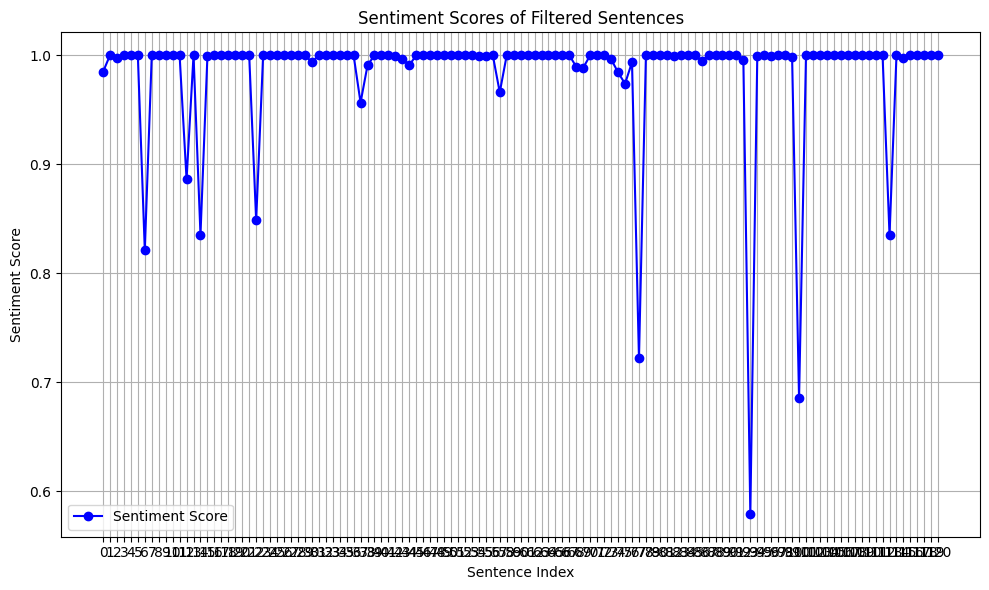

In [73]:
# Step 7: Plotting the sentiment scores of filtered sentences
if filtered_sentences:
    # Extract sentiment scores for plotting
    y = [score for _, _, score in filtered_sentences]
    x = range(len(filtered_sentences))  # x-axis is the sentence index

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label='Sentiment Score')

    # Customize the plot
    plt.title('Sentiment Scores of Filtered Sentences')
    plt.xlabel('Sentence Index')
    plt.ylabel('Sentiment Score')
    plt.grid(True)
    plt.xticks(x)  # Show x-ticks for each sentence
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("No filtered sentences with sentiment scores greater than or equal to 0.5.")



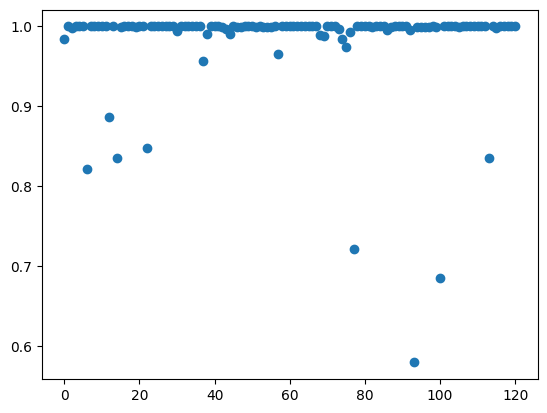

In [72]:
plt.scatter(x, y)

In [14]:
## Compute the similarities between Sentences

In [77]:
# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(cleaned_sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)
# tensor([[1.0000, 0.6660, 0.1046],
#         [0.6660, 1.0000, 0.1411],
#         [0.1046, 0.1411, 1.0000]])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(223, 384)
tensor([[1.0000, 0.3421, 0.0795,  ..., 0.3928, 0.0174, 0.2503],
        [0.3421, 1.0000, 0.2381,  ..., 0.5578, 0.5764, 0.3264],
        [0.0795, 0.2381, 1.0000,  ..., 0.2112, 0.1090, 0.0697],
        ...,
        [0.3928, 0.5578, 0.2112,  ..., 1.0000, 0.1871, 0.1778],
        [0.0174, 0.5764, 0.1090,  ..., 0.1871, 1.0000, 0.4007],
        [0.2503, 0.3264, 0.0697,  ..., 0.1778, 0.4007, 1.0000]])


In [20]:
### Group similar sentences using similarities (5 clusters)

In [78]:
embeddings

array([[-0.00110537,  0.0159439 , -0.01621509, ..., -0.02262651,
        -0.08636938,  0.05863721],
       [-0.04489856, -0.08297476,  0.05123191, ..., -0.07184947,
        -0.04010465, -0.01722866],
       [-0.07108042,  0.02923083, -0.06646982, ..., -0.02352248,
         0.0590254 , -0.06007127],
       ...,
       [-0.01002732, -0.03635307,  0.03807943, ..., -0.00447208,
        -0.03119446,  0.04642906],
       [ 0.00716699, -0.05871334,  0.01429071, ..., -0.13632229,
        -0.04009097, -0.04055219],
       [-0.02875478, -0.01742215, -0.01770884, ..., -0.02467913,
        -0.08468493,  0.0651092 ]], dtype=float32)

In [ ]:
### Find the best number of clusters

In [86]:
## K-Means

# Assuming 'filtered_sentences' contains the cleaned sentences, labels, and sentiment scores
# Extract scores and cleaned sentences from filtered_sentences
scores = [score for _, _, score in filtered_sentences]  # Extract numerical scores
cleaned_sentences = [sentence for sentence, _, _ in filtered_sentences]  # Extract cleaned sentences

# Convert scores to a 2D array for clustering
scores_array = np.array(scores).reshape(-1, 1)  # Reshape to (n_samples, 1)

# Apply KMeans clustering with different numbers of clusters
for n_clusters in range(2, 10):  # Try clustering with 2 to 9 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scores_array)
    print(f"Number of clusters: {n_clusters}")
    print(f"Cluster centers: {kmeans.cluster_centers_.flatten()}")



Number of clusters: 2
Cluster centers: [0.99811021 0.77661308]
Number of clusters: 3
Cluster centers: [0.99811021 0.84521456 0.66227728]
Number of clusters: 4
Cluster centers: [0.99811021 0.84521456 0.70365241 0.57952702]
Number of clusters: 5
Cluster centers: [0.99926728 0.84521456 0.70365241 0.57952702 0.97311741]
Number of clusters: 6
Cluster centers: [0.99926728 0.83499157 0.70365241 0.57952702 0.97311741 0.88610649]
Number of clusters: 7
Cluster centers: [0.99974365 0.83499157 0.70365241 0.57952702 0.96550794 0.88610649
 0.9895097 ]
Number of clusters: 8
Cluster centers: [0.99974365 0.83499157 0.68530065 0.57952702 0.88610649 0.96550794
 0.9895097  0.72200418]
Number of clusters: 9
Cluster centers: [0.99974365 0.83960319 0.68530065 0.57952702 0.88610649 0.96550794
 0.9895097  0.72200418 0.82115674]


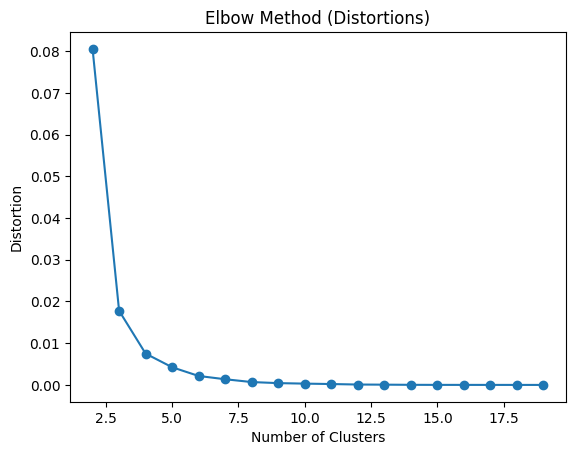

In [90]:


# Extract the sentiment scores and cleaned sentences from filtered_sentences
scores = [score for _, _, score in filtered_sentences]
cleaned_sentences = [sentence for sentence, _, _ in filtered_sentences]

# Convert scores to a 2D array for clustering
scores_array = np.array(scores).reshape(-1, 1)  # Reshape to (n_samples, 1)

# Lists to hold distortion (sum of squared distances) 
distortions = []

# Try different numbers of clusters (range from 2 to 19)
range_clusters = range(2, 20)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scores_array)
    distortions.append(kmeans.inertia_)  # Sum of squared distances to cluster centers
    

# Elbow Method Plot (Distortions)
plt.plot(range_clusters, distortions, marker='o')
plt.title("Elbow Method (Distortions)")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()


Cluster -1: 121 points


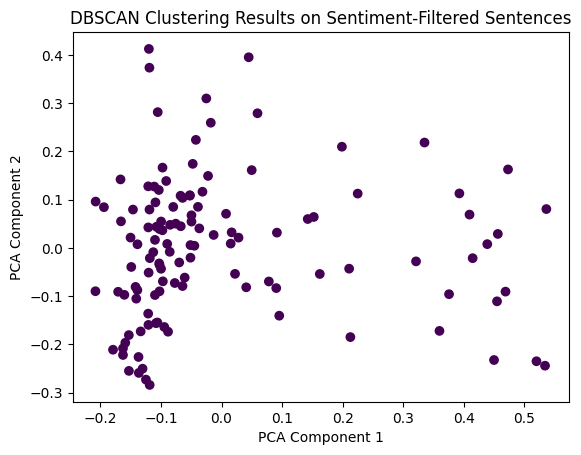

In [82]:

# Convert the raw text into TF-IDF features using filtered sentences
vectorizer = TfidfVectorizer()
embeddings = vectorizer.fit_transform([sentence for sentence, _, _ in filtered_sentences])  # Use cleaned_sentences

# Run DBSCAN on the embeddings
dbscan = DBSCAN(eps=0.5, min_samples=3)
cluster_labels = dbscan.fit_predict(embeddings.toarray())  # Convert sparse matrix to array for DBSCAN

# Count the number of occurrences of each label
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} points")

# Dimensionality Reduction (e.g., PCA) for visualization
pca = PCA(n_components=2)  # Reduce to 2D for plotting
reduced_embeddings = pca.fit_transform(embeddings.toarray())

# Plot the results
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.title("DBSCAN Clustering Results on Sentiment-Filtered Sentences")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
## Silhouette Score

In [91]:

# Convert the raw text into TF-IDF features using filtered sentences
vectorizer = TfidfVectorizer()
embeddings = vectorizer.fit_transform([sentence for sentence, _, _ in filtered_sentences])  # Use cleaned_sentences

# For KMeans clustering, we need to apply clustering for different values of k (2 to 9 clusters)
for k in range(2, 10):  # Test 2 to 9 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)  # Perform clustering
    score = silhouette_score(embeddings, labels)  # Calculate silhouette score
    print(f"Number of clusters: {k}, Silhouette score: {score:.4f}")


Number of clusters: 2, Silhouette score: 0.0050
Number of clusters: 3, Silhouette score: 0.0062
Number of clusters: 4, Silhouette score: 0.0159
Number of clusters: 5, Silhouette score: 0.0152
Number of clusters: 6, Silhouette score: 0.0174
Number of clusters: 7, Silhouette score: 0.0109
Number of clusters: 8, Silhouette score: 0.0091
Number of clusters: 9, Silhouette score: 0.0073


In [103]:

# Suppress warnings to avoid unnecessary output during clustering
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"


# Perform KMeans clustering with parallelism control
num_clusters = 2  # Number of clusters you want to use
with threadpool_limits(limits=1, user_api='openmp'):  # Limit parallelism to 1 thread
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)  # Fit the KMeans model to the embeddings

# Assign clusters
cluster_labels = kmeans.labels_  # Get the labels for each sentence
clusters = {i: [] for i in range(num_clusters)}  # Initialize dictionary for clusters

# Group sentences into their respective clusters
for idx, label in enumerate(cluster_labels):
    clusters[label].append(filtered_sentences[idx][0])  # Use filtered_sentences to map clusters

# Print clusters
for cluster, cluster_sentences in clusters.items():
    print(f"Cluster {cluster}:")
    for sentence in cluster_sentences:
        print(f" - {sentence}")



Cluster 0:
 - Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion.
 - Owing to our increasing diverse content and wider awareness of our brand, we are reaching a much broader audience.
 - For the second quarter, MAUs were 172 million, up 55% and DAUs were up 52% to 51 million, both on a year-over-year basis.
 - Along with the expanded user base, user engagement continues to be strong.
 - As we move into our peak summer season, with solid execution of our initiatives, we're looking forward to further building on our user growth momentum.
 - We continue to rollout more premium content and services, strengthen our monetization capabilities, and we are increasingly converting traffic to paid users.
 - Our MPUs were up 105% year-over-year, reaching 12.9 million in the second quarter, and our paying ratio improved to 7.5%, compared to 5.7% from the same period last year.
 - 

In [ ]:
### Step 3: Aggregate Sentiment by Clusters. Once you have grouped sentences into clusters, aggregate the sentiment scores of all sentences in a cluster to infer the overall sentiment of that group.

In [104]:
# Initialize dictionary to aggregate sentiment scores by cluster
cluster_sentiments = {i: {"positive": 0, "negative": 0, "neutral": 0} for i in range(num_clusters)}

# Loop through each sentence, corresponding cluster, and sentiment results
for idx, label in enumerate(cluster_labels):
    sentiment = filtered_sentences[idx][1]  # Get the sentiment label for the sentence from filtered_sentences
    score = filtered_sentences[idx][2]  # Get the sentiment score for the sentence
    
    # Only aggregate if the sentiment is non-neutral
    if sentiment != 'neutral':
        sentiment_label = sentiment.lower()  # Ensure the sentiment is lowercase
        cluster_sentiments[label][sentiment_label] += score

# Print aggregated sentiment scores per cluster
for cluster, sentiments in cluster_sentiments.items():
    print(f"Cluster {cluster}: {sentiments}")


Cluster 0: {'positive': 63.324306070804596, 'negative': 0.9847716689109802, 'neutral': 0}
Cluster 1: {'positive': 53.96827632188797, 'negative': 0.7220041751861572, 'neutral': 0}


In [46]:
### Compute the weighted score for each cluster

In [105]:
# Initialize the dictionary to hold the total sentiment scores and sentence counts for each cluster
cluster_sentiments = {i: {"total_score": 0, "num_sentences": 0} for i in range(num_clusters)}

# Loop through each sentence, its sentiment, and its corresponding cluster label
for idx, label in enumerate(cluster_labels):
    sentiment = sentiment_results[idx][0]  # Get sentiment result for the sentence
    score = sentiment['score']  # Get the sentiment score for the sentence
    
    # Update the total score for the cluster
    cluster_sentiments[label]["total_score"] += score
    
    # Update the sentence count for the cluster
    cluster_sentiments[label]["num_sentences"] += 1

# Calculate and print the weighted sentiment score for each cluster
for cluster, sentiments in cluster_sentiments.items():
    total_score = sentiments["total_score"]
    num_sentences = sentiments["num_sentences"]
    
    # Avoid division by zero
    if num_sentences > 0:
        weighted_score = total_score / num_sentences
    else:
        weighted_score = 0
    
    print(f"Cluster {cluster}: Weighted Sentiment Score: {weighted_score:.2f}")


KeyError: 0

In [106]:
### Topic Modeling: LLatent Dirichlet Allocation (LDA)
## LDA can help identify underlying topics in the text data and give a clearer thematic understanding of each cluster.

In [107]:
# Step 1: Convert text to a TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(cleaned_sentences)  # Assuming `cleaned_sentences` contains your text data
feature_names = vectorizer.get_feature_names_out()

# Step 2: Apply Latent Dirichlet Allocation (LDA)
lda = LatentDirichletAllocation(n_components=2, random_state=42)  # 3 topics as an example
lda.fit(tfidf_matrix)

# Step 3: Display top words per topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))  # Top 10 words per topic



Topic 0:
year content good growth user increase half game platform revenues
Topic 1:
year quarter second million new high brand strong bilibili growth


In [ ]:
### Labeling the Clusters with Themes

Note: you may need to restart the kernel to use updated packages.


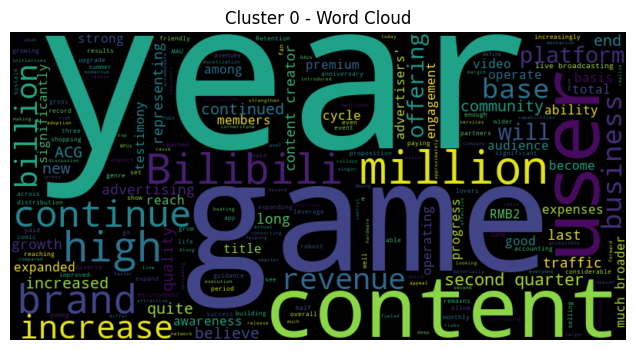

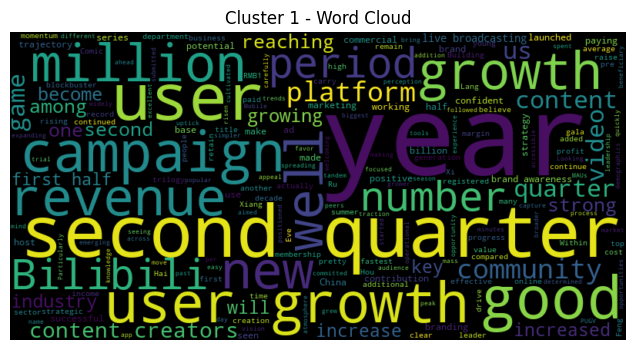

In [108]:
%pip install wordcloud
from wordcloud import WordCloud

# Visualizing the most frequent words in each cluster (Word Cloud)
for cluster, cluster_sentences in clusters.items():
    text = " ".join(cluster_sentences)
    wordcloud = WordCloud(width=800, height=400).generate(text)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster} - Word Cloud")
    plt.show()

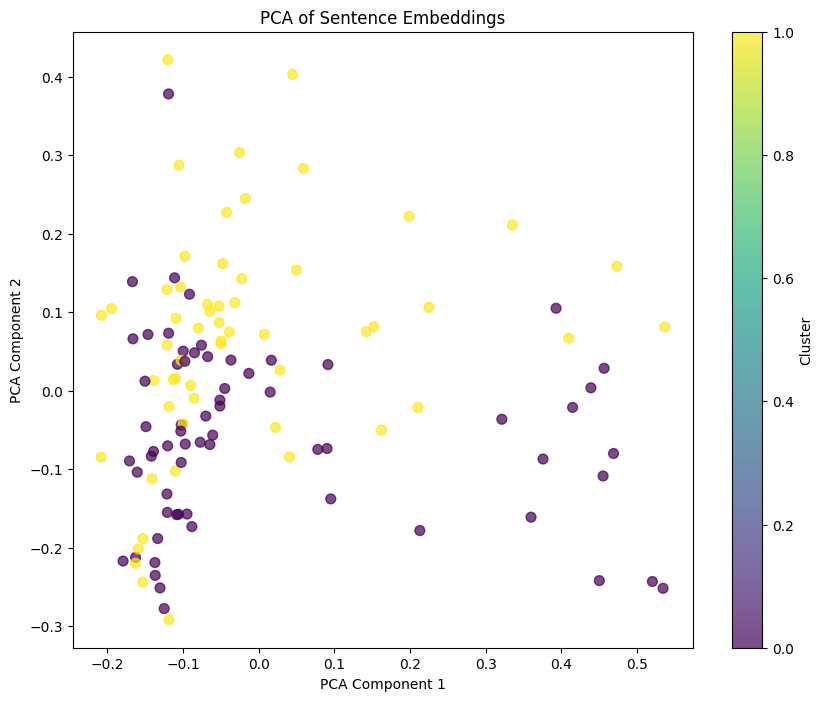

In [110]:
# Use PCA to reduce sentence embeddings to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)  # 'embeddings' is the array of sentence embeddings

# Plotting the PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('PCA of Sentence Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [52]:
### Tokenizing Each Chunk

In [54]:

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example of long text
long_text = data["transcript"].iloc[0] # Replace with your 8000-length text

# Step 1: Split the text into sentences using NLTK (or use your preferred method)
nltk.download('punkt')
sentences = nltk.sent_tokenize(long_text)

# Step 2: Tokenize each sentence individually and ensure we stay within the 512 token limit
tokens_list = []
current_chunk = []

# Loop through sentences and add them to the current chunk
for sentence in sentences:
    # Tokenize the sentence
    tokens = tokenizer(sentence, return_tensors='pt', padding=False, truncation=False)
    
    # Add the tokenized sentence to the current chunk
    if sum([len(chunk) for chunk in current_chunk]) + len(tokens['input_ids'][0]) <= 512:
        current_chunk.append(tokens['input_ids'][0])
    else:
        # If the current chunk exceeds the token limit, store it and start a new chunk
        tokens_list.append(current_chunk)
        current_chunk = [tokens['input_ids'][0]]

# Add the last chunk if it has content
if current_chunk:
    tokens_list.append(current_chunk)

# Now tokens_list contains the tokenized chunks with a max of 512 tokens each.
print(f"Number of chunks: {len(tokens_list)}")


Number of chunks: 16


[nltk_data] Downloading package punkt to /Users/yfd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
## Option 1: Bert

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

In [55]:
from torch import no_grad

# Assuming 'model' is your pre-trained BERT model for sentiment/emotion detection
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Example of getting predictions for each chunk
for chunk in tokens_list:
    with no_grad():
        # Convert the chunk into a batch format (usually we process a batch of inputs)
        batch_tokens = {'input_ids': torch.stack(chunk)}  # Convert list of tensors into a batch
        outputs = model(**batch_tokens)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        print(f"Predicted Class: {predicted_class}, Probabilities: {probabilities}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: stack expects each tensor to be equal size, but got [23] at entry 0 and [10] at entry 1

In [29]:
from torch import nn

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 classes for binary sentiment

# Set model to evaluation mode
model.eval()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
### Tokenize the text 

In [30]:
# Example text
text = "The market is doing great today!"

# Tokenize the text
inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)


In [ ]:
### 5. Predict Sentiment 
# Now, you can pass the tokenized text into the model to obtain sentiment predictions. For binary sentiment analysis, the model will output probabilities for each class (positive or negative sentiment)

In [31]:
# Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Model outputs logits for each class

# Apply softmax to get probabilities
probabilities = torch.softmax(logits, dim=1)

# Get the predicted sentiment class
predicted_class = torch.argmax(probabilities, dim=1).item()


In [32]:
# Map the predicted class to sentiment labels
sentiment_labels = ['negative', 'positive']
predicted_sentiment = sentiment_labels[predicted_class]
print(f"Sentiment: {predicted_sentiment}")


Sentiment: positive


In [ ]:
### Option 1: Split the Long Text Manually and Avoid Truncation 
# In this approach, you’ll split your long text into smaller chunks without specifying a max_length during tokenization, so the tokenizer won't truncate. Instead, you’ll break the text into meaningful chunks based on sentences or paragraphs, ensuring each chunk stays within BERT's maximum token limit (usually 512 tokens for bert-base-uncased).

In [43]:
# A helper function to split the text into smaller chunks that fit the model's token limit
def chunk_text(text, tokenizer, chunk_size=510):
    tokens = tokenizer(text, return_tensors='pt', padding=False, truncation=False)
    token_ids = tokens['input_ids'][0].tolist()
    
    # Split token list into chunks
    chunks = [token_ids[i:i + chunk_size] for i in range(0, len(token_ids), chunk_size)]
    
    # Reconstruct the text for each chunk
    chunked_texts = [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]
    return chunked_texts

# Example long text
long_text = data["transcript"].iloc[0] 

# Chunk the long text
chunked_texts = chunk_text(long_text, tokenizer)

# Print the first chunk
print(chunked_texts[0])


Prepared Remarks:
Operator
Good day, and welcome to the Bilibili 2020 Second Quarter Earnings Conference Call. Today's conference is being recorded.
At this time, I would like to turn the conference over to Juliet Yang, Senior Director of Investor Relations. Please go ahead.
Juliet Yang -- Senior Director of Investor Relations
Thank you, operator.
Please note the discussion today will contain forward-looking statements relating to the Company's future performance, and are intended to qualify for the Safe Harbor from liability, as established by the US Private Securities Litigation Reform Act. Such statements are not guarantees of future performance and are subject to certain risks and uncertainties, assumptions and other factors. Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion. A general discussion of the risk factors that could affect Bilibili's business and finan

In [48]:
# Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Model outputs logits for each class

# Apply softmax to get probabilities
probabilities = torch.softmax(logits, dim=1)

# Get the predicted sentiment class
predicted_class = torch.argmax(probabilities, dim=1).item()


IndexError: index out of range in self